# Import tools - use a QIIME2 kernel or environment

In [1]:
import pandas as pd
%matplotlib inline
import qiime2
from qiime2 import Artifact
from tempfile import mkdtemp
from qiime2.plugins import demux, deblur, quality_filter, \
                           metadata, feature_table, alignment, \
                           phylogeny, diversity, emperor, feature_classifier, \
                           taxa, composition
from qiime2.plugins import fragment_insertion
from qiime2.plugins.fragment_insertion.methods import filter_features
from qiime2.plugins.feature_table.methods import filter_samples
from qiime2.plugins.feature_table.visualizers import summarize
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pylab
from scipy.optimize import curve_fit
import biom

## Import data

In [2]:
# Import feature-table and taxonomy files in QZA format 
table = Artifact.load('141988_all.biom.qza')
taxonomy = Artifact.load('taxonomy(2).qza')

## Collapse and subset data to include only Katharoseq controls


In [12]:
# collapsed table to genus level
t6 = taxa.methods.collapse(table = table,
                           taxonomy = taxonomy,
                           level = 6)
# import collapsed table as pandas dataframe
df = t6.collapsed_table.view(pd.DataFrame)
# subset out Zymo mock community samples
zymo = df[df.index.str.contains('.prev')]
# ensure table values are numeric
zymo = zymo.astype(float)


In [13]:
# quick visual check that top 7 taxa make up most of the reads in highest input sample ("d1")
max_input = zymo[zymo.index.str.contains("d1")]
zymoT = max_input.T
zymoT.sort_values(zymoT.columns[0], ascending = False).head(10)


IndexError: index 0 is out of bounds for axis 0 with size 0

## Calculate reads aligning to mock community
### NOTE: Select one of the three options below based on the type of Katharoseq control used

### Option 1: ATCC Mock Community Standard (still needs validation with real data - it is likely that a higher taxonomic level for *Clostridium* will have to be added, but we need to check first)
https://urldefense.proofpoint.com/v2/url?u=https-3A__www.atcc.org_products_msa-2D2014&d=DwIGAg&c=-35OiAkTchMrZOngvJPOeA&r=JZIhRLe8LYVxCij0w2LVB69druPdj_BdYvbW4MOnEIs&m=91Hb5vuyk--zfPyk7qwAjh03tMOvs-yp9qFsLDIhM3psW1sL9-RVR44nK7J7iw95&s=aXrAlH1pAyqUrOb7JtlawZYI7OKLT8wMzDQFg2kizJM&e= 

In [ ]:
# Calculate the total number of reads per sample
zymo['deblur_reads'] = zymo.sum(axis=1)

# Calculate the number of reads aligning to the mock community input genera
zymo['zymo_reads'] = zymo[['d__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Clostridium',
                           'd__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;__',
                           'd__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Escherichia-Shigella',
                           'd__Bacteria;p__Firmicutes;c__Bacilli;o__Staphylococcales;f__Staphylococcaceae;g__Staphylococcus']].sum(axis=1)

# Calculate the percent correctly assigned
zymo['correct_assign'] = zymo['zymo_reads'] / zymo['deblur_reads']


### Option 2: Zymo ZYMOBIOMICS Mock Community Standard (works with versions I and II)
https://urldefense.proofpoint.com/v2/url?u=https-3A__www.zymoresearch.com_collections_zymobiomics-2Dmicrobial-2Dcommunity-2Dstandards_products_zymobiomics-2Dmicrobial-2Dcommunity-2Dstandard-255Cn&d=DwIGAg&c=-35OiAkTchMrZOngvJPOeA&r=JZIhRLe8LYVxCij0w2LVB69druPdj_BdYvbW4MOnEIs&m=91Hb5vuyk--zfPyk7qwAjh03tMOvs-yp9qFsLDIhM3psW1sL9-RVR44nK7J7iw95&s=6-OKPm21dCQpU1oT909fhdvpoSTXtzAPnBBxpRoSqt4&e= https://urldefense.proofpoint.com/v2/url?u=https-3A__www.zymoresearch.com_collections_zymobiomics-2Dmicrobial-2Dcommunity-2Dstandards_products_zymobiomics-2Dmicrobial-2Dcommunity-2Dstandard-2Dii-2Dlog-2Ddistribution&d=DwIGAg&c=-35OiAkTchMrZOngvJPOeA&r=JZIhRLe8LYVxCij0w2LVB69druPdj_BdYvbW4MOnEIs&m=91Hb5vuyk--zfPyk7qwAjh03tMOvs-yp9qFsLDIhM3psW1sL9-RVR44nK7J7iw95&s=ccmxKzrQ2OpXSBxEvVHEgiu27YuEILn1nnyBH4S_g3k&e= 

In [10]:
# Calculate the total number of reads per sample
zymo['deblur_reads'] = zymo.sum(axis=1)

# Calculate the number of reads aligning to the mock community input genera
zymo['zymo_reads'] = zymo[['d__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Listeriaceae;g__Listeria',
                           'd__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Pseudomonadaceae;g__Pseudomonas',
                           'd__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Bacillus',
                           'd__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;__',
                           'd__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Escherichia-Shigella',
                           'd__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus',
                           'd__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Enterococcaceae;g__Enterococcus',
                           'd__Bacteria;p__Firmicutes;c__Bacilli;o__Staphylococcales;f__Staphylococcaceae;g__Staphylococcus']].sum(axis=1)

# Calculate the percent correctly assigned
zymo['correct_assign'] = zymo['zymo_reads'] / zymo['deblur_reads']


### Option 3: 'Classic Katharoseq' - *Bacillus subtilis* and *Paracoccus denitrificans*

In [14]:
# Calculate the total number of reads per sample
zymo['deblur_reads'] = zymo.sum(axis=1)
# calculate the number of reads aligning to the mock community input genera
zymo['zymo_reads'] = zymo[['d__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Bacillus',
       'd__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodobacterales;f__Rhodobacteraceae;g__Paracoccus']].sum(axis=1)
# calculate the percent correctly assigned
zymo['correct_assign'] = zymo['zymo_reads'] / zymo['deblur_reads']


In [15]:
zymo

,Unassigned;__;__;__;__;__,d__Bacteria;__;__;__;__;__,d__Bacteria;p__Acidobacteriota;c__Holophagae;o__Holophagales;f__Holophagaceae;g__Geothrix,d__Bacteria;p__Actinobacteriota;c__Acidimicrobiia;o__Microtrichales;f__Ilumatobacteraceae;g__CL500-29_marine_group,d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;__,d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Actinomyces,d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Actinomycetaceae,d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Arcanobacterium,d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Mobiluncus,d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Trueperella,...,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Steroidobacterales;f__Steroidobacteraceae;g__uncultured,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Thiotrichales;f__Thiotrichaceae;g__Thiothrix,d__Bacteria;p__Synergistota;c__Synergistia;o__Synergistales;f__Synergistaceae;g__Jonquetella,d__Bacteria;p__Synergistota;c__Synergistia;o__Synergistales;f__Synergistaceae;g__Pyramidobacter,d__Bacteria;p__Thermotogota;c__Thermotogae;o__Thermotogales;f__Fervidobacteriaceae;g__Fervidobacterium,d__Eukaryota;p__Vertebrata;c__Mammalia;o__Mammalia;f__Mammalia;g__Mammalia,d__Eukaryota;p__Zoopagomycota;c__Entomophthoromycetes;o__Entomophthorales;f__Entomophthoraceae;__,deblur_reads,zymo_reads,correct_assign
14385.Katharo5.2speciesmock.1E.5thousand.prev,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1397.0,0.0,0.000000
14385.Katharo5.2speciesmock.1B.5million.prev,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6398.0,5932.0,0.927165
14385.Katharo5.2speciesmock.1F.5hundred.prev,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,444.0,0.0,0.000000
14385.Katharo5.2speciesmock.1H.5.prev,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,943.0,0.0,0.000000
14385.Katharo5.2speciesmock.1G.50.prev,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,564.0,0.0,0.000000
14385.Katharo5.2speciesmock.1D.50thousand.prev,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,636.0,75.0,0.117925
14385.Katharo5.2speciesmock.1C.500thousand.prev,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1810.0,425.0,0.234807
14385.Katharo5.2speciesmock.1A.50million.prev,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31431.0,27558.0,0.876778


In [16]:
zymo

,Unassigned;__;__;__;__;__,d__Bacteria;__;__;__;__;__,d__Bacteria;p__Acidobacteriota;c__Holophagae;o__Holophagales;f__Holophagaceae;g__Geothrix,d__Bacteria;p__Actinobacteriota;c__Acidimicrobiia;o__Microtrichales;f__Ilumatobacteraceae;g__CL500-29_marine_group,d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;__,d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Actinomyces,d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Actinomycetaceae,d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Arcanobacterium,d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Mobiluncus,d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Trueperella,...,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Steroidobacterales;f__Steroidobacteraceae;g__uncultured,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Thiotrichales;f__Thiotrichaceae;g__Thiothrix,d__Bacteria;p__Synergistota;c__Synergistia;o__Synergistales;f__Synergistaceae;g__Jonquetella,d__Bacteria;p__Synergistota;c__Synergistia;o__Synergistales;f__Synergistaceae;g__Pyramidobacter,d__Bacteria;p__Thermotogota;c__Thermotogae;o__Thermotogales;f__Fervidobacteriaceae;g__Fervidobacterium,d__Eukaryota;p__Vertebrata;c__Mammalia;o__Mammalia;f__Mammalia;g__Mammalia,d__Eukaryota;p__Zoopagomycota;c__Entomophthoromycetes;o__Entomophthorales;f__Entomophthoraceae;__,deblur_reads,zymo_reads,correct_assign
14385.Katharo5.2speciesmock.1E.5thousand.prev,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1397.0,0.0,0.000000
14385.Katharo5.2speciesmock.1B.5million.prev,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6398.0,5932.0,0.927165
14385.Katharo5.2speciesmock.1F.5hundred.prev,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,444.0,0.0,0.000000
14385.Katharo5.2speciesmock.1H.5.prev,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,943.0,0.0,0.000000
14385.Katharo5.2speciesmock.1G.50.prev,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,564.0,0.0,0.000000
14385.Katharo5.2speciesmock.1D.50thousand.prev,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,636.0,75.0,0.117925
14385.Katharo5.2speciesmock.1C.500thousand.prev,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1810.0,425.0,0.234807
14385.Katharo5.2speciesmock.1A.50million.prev,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31431.0,27558.0,0.876778


## Plotting

In [17]:
# subset out KatharoSeq columns and add in logarithim of reads for plotting
katharo = zymo[['correct_assign','deblur_reads','zymo_reads']]
katharo['log_deblur_reads'] = np.log10(katharo['deblur_reads'])


/home/kalen/miniconda3/envs/qiime2-2020.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


### Fit an allosteric sigmoid curve for extrpolating min read count #

[2.71800730e+01 3.73696514e+14]


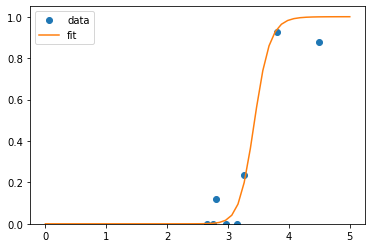

In [18]:
# define the allosteric sigmoid equation
def allosteric_sigmoid(x, h, k_prime):
    y = x ** h / (k_prime + x ** h)
    return y
 
# fit the curve to your data
popt, pcov = curve_fit(allosteric_sigmoid, katharo['log_deblur_reads'], katharo['correct_assign'], method='dogbox')
print(popt)
# plot fit curve
x = np.linspace(0, 5, 50)
y = allosteric_sigmoid(x, *popt)

# plot the fit
pylab.plot(katharo['log_deblur_reads'], katharo['correct_assign'], 'o', label='data')
pylab.plot(x,y, label='fit')
pylab.ylim(0, 1.05)
pylab.legend(loc='best')
pylab.show()


## Quantify read depths for various Katharoseq thresholds - run all to generate a comparative table

In [19]:
# 50% threshold (recommended)

# assign variables and solve for X (number of reads to pass filter)
h = popt[0]  # first value printed above graph
k = popt[1]   # second value printed above graph
y = 0.5 ## what you want to solve for

min_log_reads = np.power((k/(1/y-1)),(1/h))
min_freq_50 = np.power(10, min_log_reads).astype(int)
min_freq_50


2733

In [20]:
# 80% threshold

# assign variables and solve for X (number of reads to pass filter)
h = popt[0]  # first value printed above graph
k = popt[1]   # second value printed above graph
y = 0.8 ## what you want to solve for

min_log_reads = np.power((k/(1/y-1)),(1/h))
min_freq_80 = np.power(10, min_log_reads).astype(int)
min_freq_80


4135

In [21]:
# 90% threshold

# assign variables and solve for X (number of reads to pass filter)
h = popt[0]  # first value printed above graph
k = popt[1]   # second value printed above graph
y = 0.9 ## what you want to solve for

min_log_reads = np.power((k/(1/y-1)),(1/h))
min_freq_90 = np.power(10, min_log_reads).astype(int)
min_freq_90


5322

In [22]:
# 95% threshold

# assign variables and solve for X (number of reads to pass filter)
h = popt[0]  # first value printed above graph
k = popt[1]   # second value printed above graph
y = 0.95 ## what you want to solve for

min_log_reads = np.power((k/(1/y-1)),(1/h))
min_freq_95 = np.power(10, min_log_reads).astype(int)
min_freq_95


6760

## Quantify sample dropout based on various Katharoseq thresholds

In [46]:
# 50% threshold (recommended)

KS_table_50 = feature_table.methods.filter_samples(table = table,
                             min_frequency = min_freq_50)
df_50 = KS_table_50.filtered_table.view(pd.DataFrame)


In [47]:
# 80% threshold

KS_table_80 = feature_table.methods.filter_samples(table = table,
                             min_frequency = min_freq_80)
df_80 = KS_table_80.filtered_table.view(pd.DataFrame)


In [48]:
# 90% threshold

KS_table_90 = feature_table.methods.filter_samples(table = table,
                             min_frequency = min_freq_90)
df_90 = KS_table_90.filtered_table.view(pd.DataFrame)


In [49]:
# 95% threshold

KS_table_95 = feature_table.methods.filter_samples(table = table,
                             min_frequency = min_freq_95)
df_95 = KS_table_95.filtered_table.view(pd.DataFrame)


In [50]:
# Import collapsed tables as pandas dataframe
print("total samples =", len(df), "\n",
      "50% threshold,", len(df_50), "samples,", len(df_50)/len(df), "of total,", min_freq_50, "reads", "\n",
      "80% threshold,", len(df_80), "samples,", len(df_80)/len(df), "of total,", min_freq_80, "reads", "\n",
      "90% threshold,", len(df_90), "samples,", len(df_90)/len(df), "of total,", min_freq_90, "reads", "\n",
      "95% threshold,", len(df_95), "samples,", len(df_95)/len(df), "of total,", min_freq_95, "reads")


total samples = 95 
 50% threshold, 71 samples, 0.7473684210526316 of total, 2733 reads 
 80% threshold, 71 samples, 0.7473684210526316 of total, 4135 reads 
 90% threshold, 71 samples, 0.7473684210526316 of total, 5322 reads 
 95% threshold, 70 samples, 0.7368421052631579 of total, 6760 reads


## Filter feature-table based on a single Katharseq threshold

In [ ]:
# Rarefy using 50% threshold (recommended)
table = Artifact.load('table.qza')
table_rarefied = rarefy(table, min_freq_50).rarefied_table
table_rarefied.save('table_rarefied.qza')
